In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phabordersmote/final_data.csv
/kaggle/input/phabordersmote/pha_map.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/kaggle/input/phabordersmote/final_data.csv")

In [4]:
y = pd.read_csv("/kaggle/input/phabordersmote/pha_map.csv")

In [5]:
X = df.drop(columns=['albedo', 'rot_per', 'e', 'a', 'q', 'om', 'w', 'ma', 'ad'])

In [6]:
X.isnull().sum()

H           0
diameter    0
i           0
n           0
per         0
moid_ld     0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from imblearn.metrics import sensitivity_specificity_support, classification_report_imbalanced
from imblearn.over_sampling import BorderlineSMOTE

In [8]:
bs = BorderlineSMOTE(random_state=42)
X_resampled, y_resampled = bs.fit_resample(X, y)

In [9]:
y_resampled.value_counts()

pha
0      1309593
1      1309593
Name: count, dtype: int64

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=43)

In [11]:
X_train.shape

(2095348, 6)

In [12]:
y_train.value_counts()

pha
1      1048325
0      1047023
Name: count, dtype: int64

In [13]:
y_test.value_counts()

pha
0      262570
1      261268
Name: count, dtype: int64

In [14]:
!pip install dask

In [15]:
!python -m pip install dask distributed --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.5.2
    Uninstalling dask-2024.5.2:
      Successfully uninstalled dask-2024.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.2 requires dask==2024.5.2, but you have dask 2024.7.0 which is incompatible.


In [16]:
from dask.distributed import Client
client = Client(n_workers=16)
client

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.5.2 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36753,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:44355,Total threads: 1
Dashboard: http://127.0.0.1:40105/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:42979,


In [17]:
import joblib

In [18]:
y_train = y_train.squeeze()
y_train

1205167    0
575514     0
1212305    0
1847891    1
1411332    1
          ..
1106227    0
1525776    1
1439802    1
2484501    1
1613617    1
Name: pha, Length: 2095348, dtype: int64

In [26]:
xgb = XGBClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    xgb.fit(X_train,y_train)

In [27]:
y_pred = xgb.predict(X_test)

In [28]:
accuracy_score(y_test,y_pred)

0.9999522753217598

In [29]:
confusion_matrix(y_test,y_pred)

array([[262547,     23],
       [     2, 261266]])

In [30]:
roc_auc_score(y_test,y_pred)

0.9999523746681316

In [19]:
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBClassifier()
param_grid = {
    'objective' : [None, 'binary:logistic', 'binary:hinge'],
    'max_depth': [None, 20, 30, 50],
    'eta' : [0.0001, 0.001, 0.01, 0.1, 1],
    'tree_method' : ['auto', 'exact']
}

rand2 = RandomizedSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [32]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand2.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

In [33]:
rand2.best_params_

{'tree_method': 'exact',
 'objective': 'binary:logistic',
 'max_depth': None,
 'eta': 1}

In [34]:
rand2.best_score_

0.9999685016447153

In [36]:
##Training with best parameters
xgbest = XGBClassifier(tree_method='exact',
 objective= 'binary:logistic',
 max_depth=None,
 eta=1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    xgbest.fit(X_train,y_train)
y_pred = xgbest.predict(X_test)

In [37]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



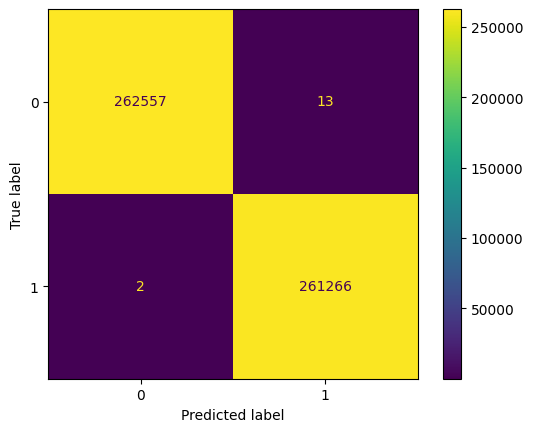

In [38]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=xgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbest.classes_)
disp.plot()
plt.show()

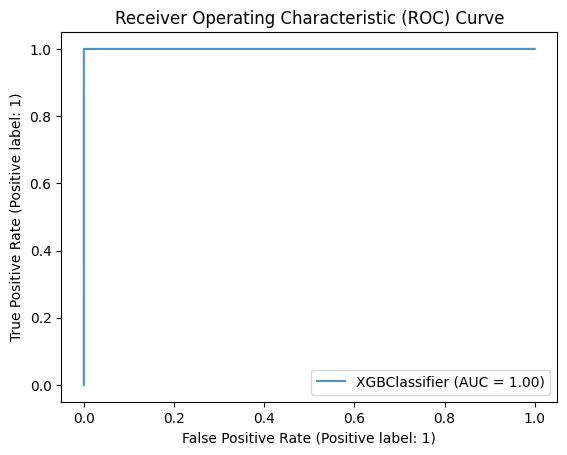

In [40]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(xgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [41]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99995049, 0.99999235]), array([0.99999235, 0.99995049]), array([262570, 261268]))


In [42]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999714172091683, 0.9999714172091683, None)


In [43]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999713651930559, 0.9999713651930559, None)


In [44]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999713651930559, 0.9999714692252806, None)


In [45]:
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_test)

[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [46]:
accuracy_score(y_test,y_pred)

0.9999007326692604

In [47]:
confusion_matrix(y_test,y_pred)

array([[262535,     35],
       [    17, 261251]])

In [48]:
roc_auc_score(y_test,y_pred)

0.9999008174627567

In [54]:
lgb = LGBMClassifier()
param_grid = {
    'num_leaves': [30, 50, 70],
    'num_iterations': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
}

rand3 = RandomizedSearchCV(lgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [55]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand3.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No fu

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requiremen

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requiremen

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [56]:
rand3.best_params_

{'num_leaves': 70,
 'num_iterations': 100,
 'max_depth': 50,
 'learning_rate': 0.1}

In [57]:
rand3.best_score_

0.9999255493523037

In [58]:
##Training with best parameters
lgbest = LGBMClassifier(num_leaves= 70,
 num_iterations= 100,
 max_depth= 50,
 learning_rate= 0.1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    lgbest.fit(X_train,y_train)
y_pred = lgbest.predict(X_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [59]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



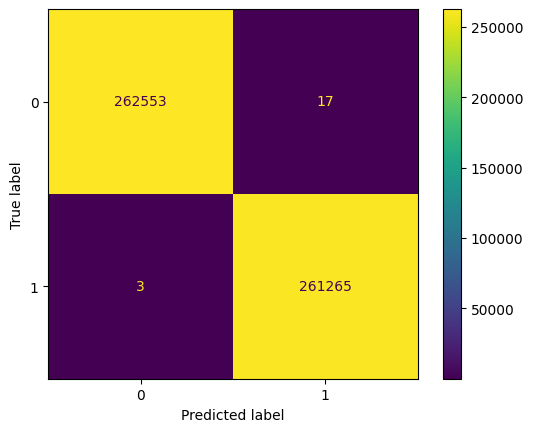

In [60]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=lgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgbest.classes_)
disp.plot()
plt.show()

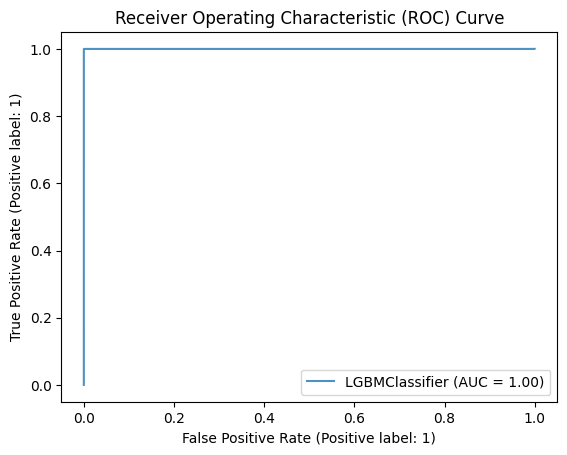

In [61]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(lgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [62]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99993526, 0.99998852]), array([0.99998852, 0.99993526]), array([262570, 261268]))


In [63]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999618864490115, 0.9999618864490115, None)


In [64]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999618202574079, 0.9999618202574079, None)


In [65]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999618202574079, 0.9999619526406152, None)


In [23]:
histgb = HistGradientBoostingClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    histgb.fit(X_train,y_train)
y_pred = histgb.predict(X_test)

In [24]:
accuracy_score(y_test,y_pred)

0.9999198225405564

In [25]:
confusion_matrix(y_test,y_pred)

array([[262530,     40],
       [     2, 261266]])

In [26]:
roc_auc_score(y_test,y_pred)

0.9999200023483693

In [34]:
param_grid = {
    'max_iter': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1]
}

rand4 = RandomizedSearchCV(histgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [35]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand4.fit(X_train,y_train)

In [36]:
rand4.best_params_

{'max_iter': 500, 'max_depth': None, 'learning_rate': 0.1}

In [30]:
rand4.best_score_

0.9999303218144334

In [44]:
##Training with best parameters
histbest = HistGradientBoostingClassifier(max_iter=500, max_depth=None, learning_rate=0.1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    histbest.fit(X_train,y_train)
y_pred = histbest.predict(X_test)

In [45]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



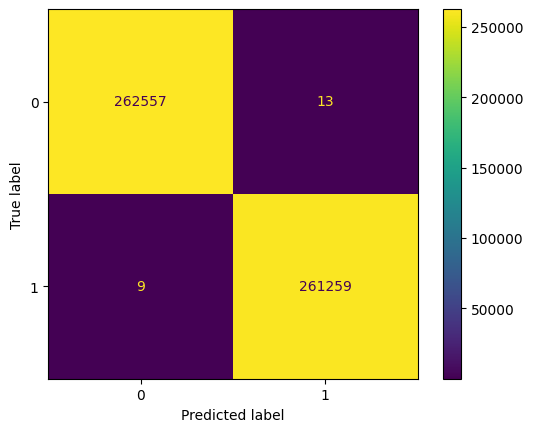

In [48]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=histbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=histbest.classes_)
disp.plot()
plt.show()

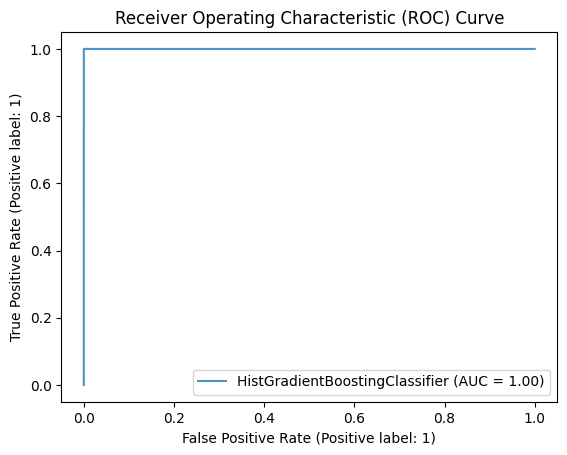

In [49]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(histbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [50]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99995049, 0.99996555]), array([0.99996555, 0.99995049]), array([262570, 261268]))


In [51]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999580210029738, 0.9999580210029738, None)


In [52]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999580022831486, 0.9999580022831486, None)


In [53]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999580022831486, 0.9999580397227991, None)
